In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

/home/rhythm/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
#reading the file
train = pd.read_csv('/home/rhythm/Research/ml/research-costh/dataset/train.csv', delimiter=";", header = 0)

In [30]:
train.describe()

,evt,E1,E2,t1,t2,x1,y1,z1,x2,y2,z2,costh
count,50001,50001,50001,50001,50001,50001,50001,50001,50001,50001,50001,50001
unique,50001,23429,25600,23452,25622,23658,23682,106,25894,25894,104,49457
top,0,0,0,-5e-09,-5e-09,-0.0640809,-0.0124847,2.20001,0.0417985,-0.0206471,-2.20001,-0.965462
freq,1,26154,23869,26154,23869,17,17,5872,15,15,5579,3


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   evt     50001 non-null  object
 1   E1      50001 non-null  object
 2   E2      50001 non-null  object
 3   t1      50001 non-null  object
 4   t2      50001 non-null  object
 5   x1      50001 non-null  object
 6   y1      50001 non-null  object
 7   z1      50001 non-null  object
 8   x2      50001 non-null  object
 9   y2      50001 non-null  object
 10  z2      50001 non-null  object
 11  costh   50001 non-null  object
dtypes: object(12)
memory usage: 4.6+ MB


In [3]:
for cols in train.columns :
    train[cols] = pd.to_numeric(train[cols], errors='coerce')
    

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   evt     50000 non-null  float64
 1   E1      50000 non-null  float64
 2   E2      50000 non-null  float64
 3   t1      50000 non-null  float64
 4   t2      50000 non-null  float64
 5   x1      50000 non-null  float64
 6   y1      50000 non-null  float64
 7   z1      50000 non-null  float64
 8   x2      50000 non-null  float64
 9   y2      50000 non-null  float64
 10  z2      50000 non-null  float64
 11  costh   50000 non-null  float64
dtypes: float64(12)
memory usage: 4.6 MB


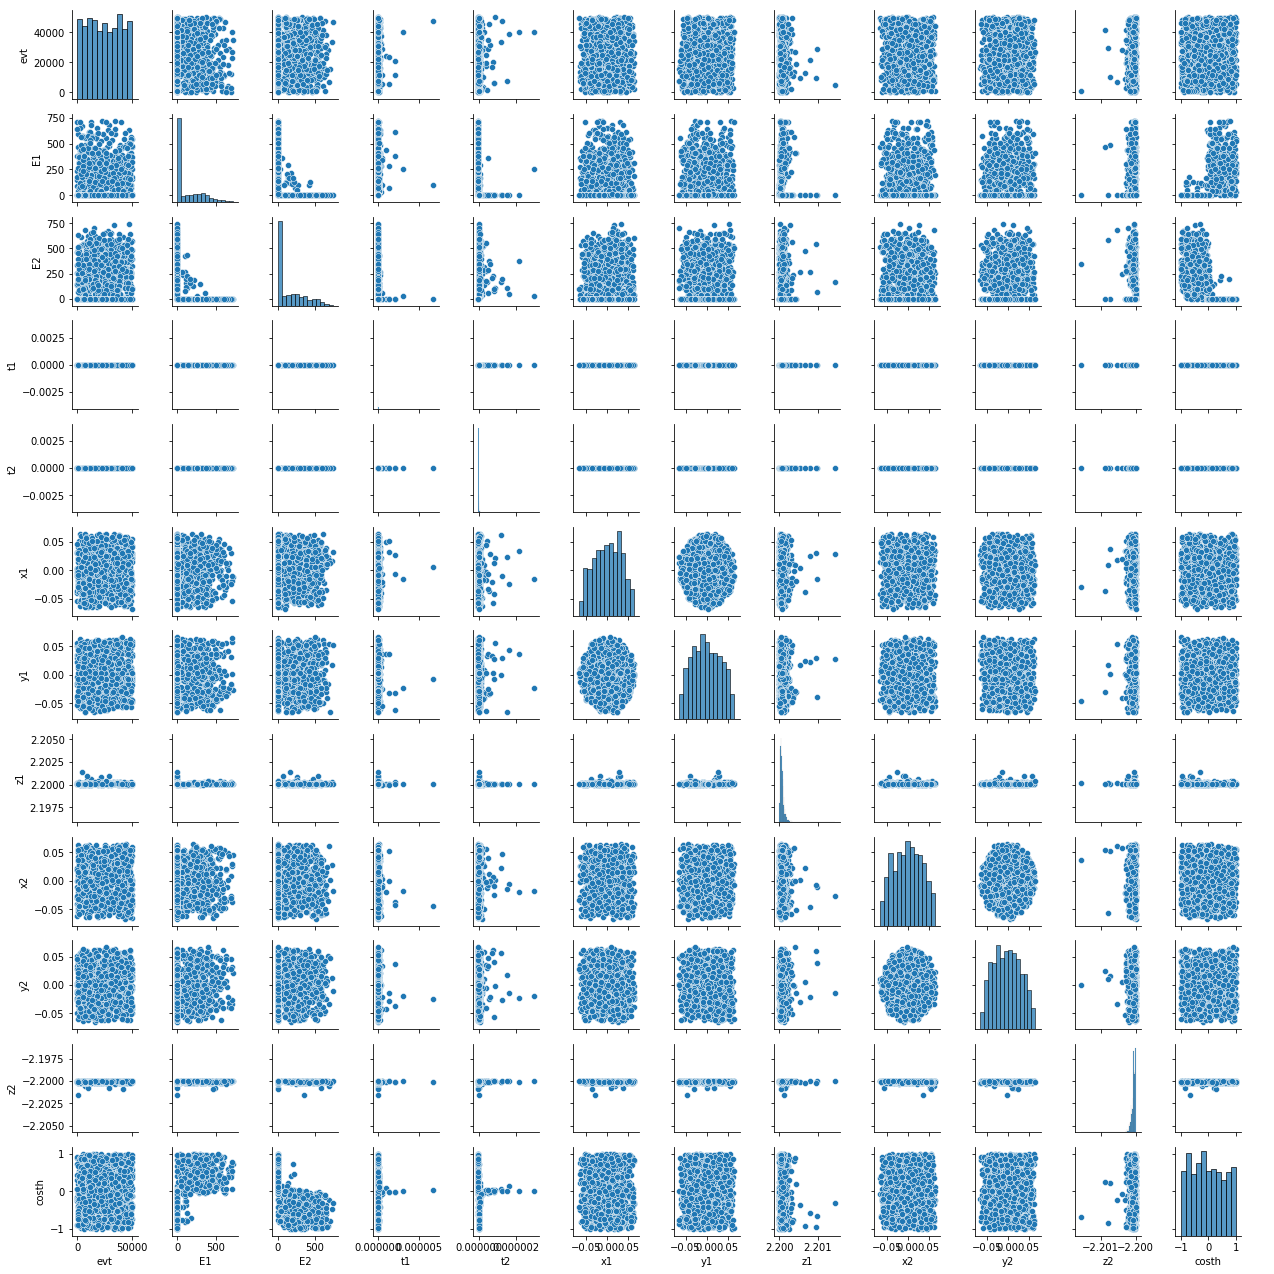

In [5]:
sns.pairplot(data = train.sample(1000), height = 1.5)

In [7]:
corr = train.corr()

[Text(0.5, 0, 'evt'),
 Text(1.5, 0, 'E1'),
 Text(2.5, 0, 'E2'),
 Text(3.5, 0, 't1'),
 Text(4.5, 0, 't2'),
 Text(5.5, 0, 'x1'),
 Text(6.5, 0, 'y1'),
 Text(7.5, 0, 'z1'),
 Text(8.5, 0, 'x2'),
 Text(9.5, 0, 'y2'),
 Text(10.5, 0, 'z2'),
 Text(11.5, 0, 'costh')]

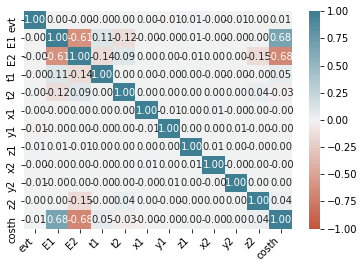

In [14]:
#let's look at the correlation matrix
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot = True, fmt =".2f"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [43]:
train.describe()

,evt,E1,E2,t1,t2,x1,y1,z1,x2,y2,z2,costh
count,50000.000000,50000.000000,50000.000000,5.000000e+04,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,138.812983,154.750947,3.091173e-08,3.429387e-08,0.000146,0.000509,2.199936,-0.000349,-0.000015,-2.200070,-0.029850
std,14433.901067,183.105329,188.490537,2.003470e-07,2.263487e-07,0.032236,0.032361,0.017042,0.032346,0.032321,0.000088,0.575545
min,0.000000,0.000000,0.000000,-5.000000e-09,-5.000000e-09,-0.068426,-0.071451,0.000000,-0.068151,-0.069590,-2.203460,-0.999928
25%,12499.750000,0.000000,0.000000,-5.000000e-09,-5.000000e-09,-0.025825,-0.025543,2.200020,-0.026362,-0.025934,-2.200090,-0.528981
50%,24999.500000,0.000000,51.375450,-5.000000e-09,5.324195e-09,0.000318,0.000434,2.200050,-0.000176,-0.000019,-2.200050,-0.044429
75%,37499.250000,266.469000,292.817500,1.876462e-08,1.954730e-08,0.026143,0.026954,2.200090,0.025677,0.026214,-2.200030,0.463040
max,49999.000000,757.665000,751.302000,7.279570e-06,9.908810e-06,0.069265,0.068058,2.203460,0.068935,0.067699,-2.200000,0.999965


In [25]:
X = train.drop('costh', axis =1 )
y = train['costh']


In [26]:
#splitting into validation and training dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_Val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [31]:
#scale the variables
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_std = sc.fit_transform(X_train)
y_std = sc.fit_transform(y_train.values.reshape(-1, 1))


In [38]:
X_std.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [40]:
cols_name = [cols for cols in X.columns]
X_std_df = pd.DataFrame(data = X_std,columns = cols_name )

In [42]:
corr_std = X_std_df.corr()

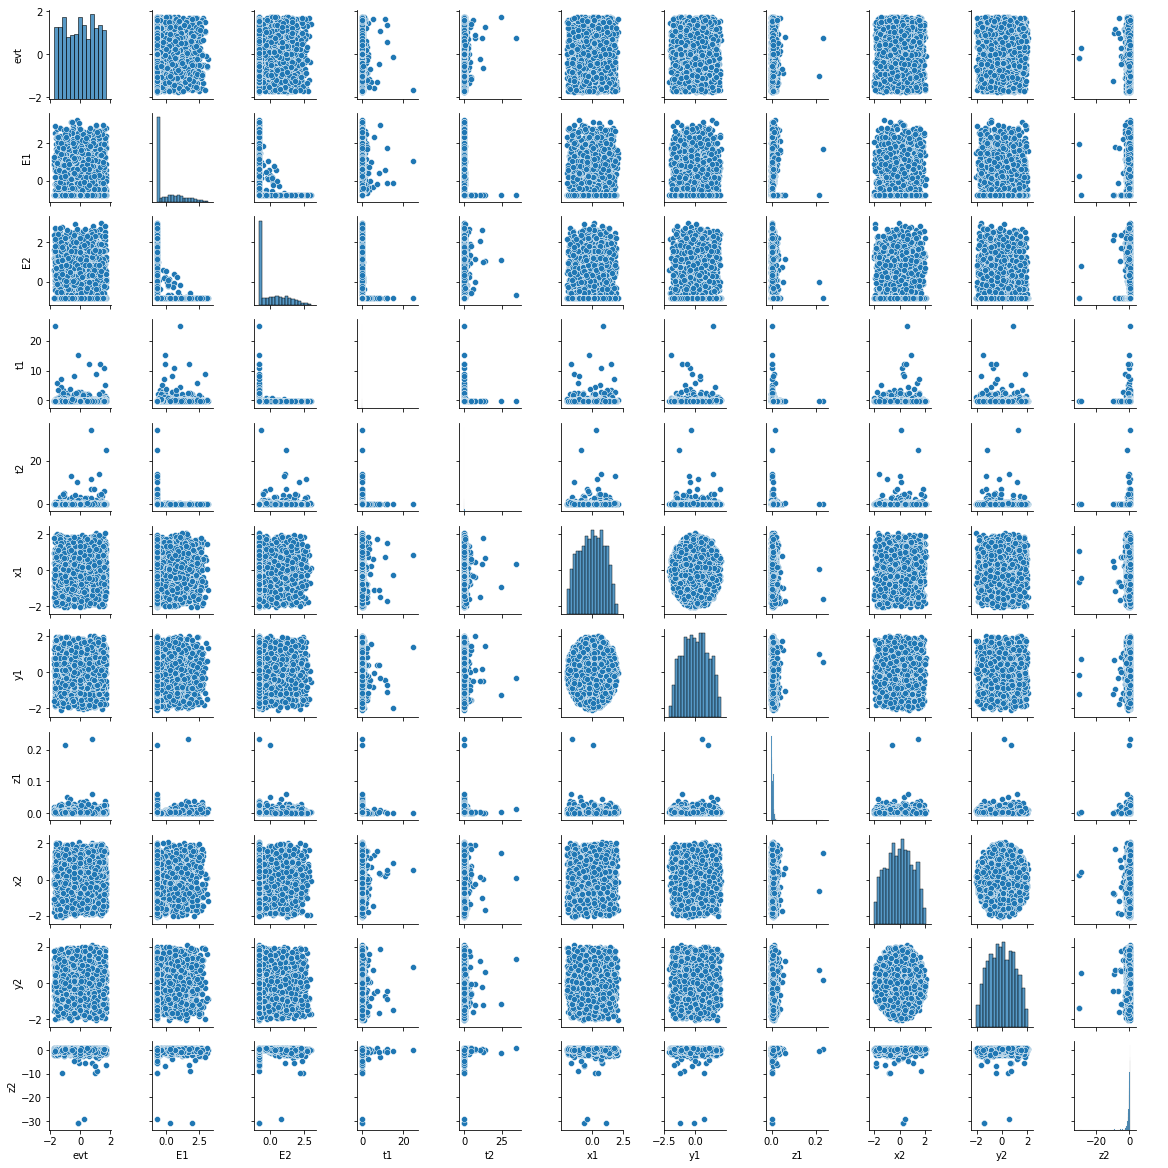

In [44]:
#let's look at the correlation matrix
sns.pairplot(data = X_std_df.sample(2000), height = 1.5)